In [1]:
# Imports, always include this at the beginning

# No science without NumPy
import numpy as np

# Matplotlib for plotting
import matplotlib.pyplot as plt
%matplotlib notebook

# Of course we want Glotaran
import glotaran as gta
# This things we just need for simulations, you can leave them out for fitting
from lmfit import Parameters

In [2]:
# First we define our model specification. See the documentation for details how to do so.
model_spec = '''
type: kinetic

parameters: 
    - 2
    - kinetic: [101e-1, 202e-5,505e-6]
    - shapes:
      - 1:
        - ["amp", 3, false]
        - ["loc", 620, false]
        - ["width", 10, false]
      - 2:
        - ["amp", 10, false]
        - ["loc", 670, false]
        - ["width", 30, false]
      - 3:
        - ["amp", 5, false]
        - ["loc", 720, false]
        - ["width", 50, false]
    - irf:
      - ["center", 0.5]
      - ["width", 5]


compartments: [s1, s2, s3]

megacomplexes:
    - label: mc1
      k_matrices: [k1]

k_matrices:
  - label: "k1"
    matrix: {
      '("s1","s1")': kinetic.1,
      '("s2","s2")': kinetic.2,
      '("s3","s3")': kinetic.3,
}       

shapes: 
  - label: gauss1
    type: gaussian
    amplitude: shapes.1.amp
    location: shapes.1.loc
    width: shapes.1.width
  - label: gauss2
    type: gaussian
    amplitude: shapes.2.amp
    location: shapes.2.loc
    width: shapes.2.width 
  - label: gauss3
    type: gaussian
    amplitude: shapes.3.amp
    location: shapes.3.loc
    width: shapes.3.width

irf: 
  - label: irf1
    type: gaussian
    center: irf.center
    width: irf.width 
    
initial_concentrations: []

datasets: 
  - label: dataset1
    type: spectral
    megacomplexes: [mc1]
    irf: irf1
    shapes:
      - [s1, gauss1]
      - [s2, gauss2]
      - [s3, gauss3]
'''

# Then we can create our model
model = gta.parse(model_spec)
print(model)

Modeltype: Kinetic

Parameter
---------
Label	Value	Min	Max	Fix
	<Parameter 'p_1', 2.0, bounds=[-inf:inf]>
	<Parameter 'p_kinetic_1', 10.1, bounds=[-inf:inf]>
	<Parameter 'p_kinetic_2', 0.00202, bounds=[-inf:inf]>
	<Parameter 'p_kinetic_3', 0.000505, bounds=[-inf:inf]>
	<Parameter 'p_shapes_1_amp', 3.0, bounds=[-inf:inf]>
	<Parameter 'p_shapes_1_loc', 620.0, bounds=[-inf:inf]>
	<Parameter 'p_shapes_1_width', 10.0, bounds=[-inf:inf]>
	<Parameter 'p_shapes_2_amp', 10.0, bounds=[-inf:inf]>
	<Parameter 'p_shapes_2_loc', 670.0, bounds=[-inf:inf]>
	<Parameter 'p_shapes_2_width', 30.0, bounds=[-inf:inf]>
	<Parameter 'p_shapes_3_amp', 5.0, bounds=[-inf:inf]>
	<Parameter 'p_shapes_3_loc', 720.0, bounds=[-inf:inf]>
	<Parameter 'p_shapes_3_width', 50.0, bounds=[-inf:inf]>
	<Parameter 'p_irf_center', 0.5, bounds=[-inf:inf]>
	<Parameter 'p_irf_width', 5.0, bounds=[-inf:inf]>


Compartments
-------------------------

['s1', 's2', 's3']

Megacomplexes
-------------

Label: mc1
K-Matrices: ['k1']

Dat

In [8]:
# Now let us define some simulation parameters
sim_params = {
    "kinetic.1": 101e-3,
    "kinetic.2": 202e-4,
    "kinetic.3": 505e-5,
}

# We also need a spectral, a time axis and some amplitudes
spectral_axis = np.arange(600, 750, 1)
time_axis = np.arange(-10, 150, 1.5)
amplitudes = [1,0.1,7]

# Now we can simulate the data
model.simulate('dataset1', {"spectral": spectral_axis, "time": time_axis}, parameter=sim_params, 
               noise=True, noise_std_dev=0.1)

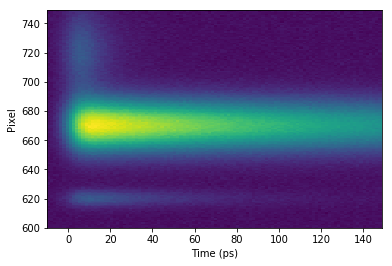

In [9]:
# Plot the simulated data

dataset = model.datasets["dataset1"]
data = dataset.data.get()

fig = plt.figure()
plt.xlabel('Time (ps)')
plt.ylabel('Pixel')
plt.pcolormesh(time_axis, spectral_axis, data)
plt.show()

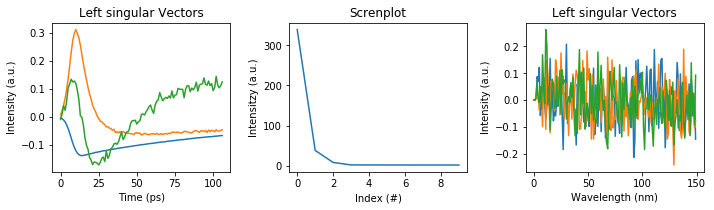

In [31]:
# Plot the SVD

lsvd, svals, rsvd = np.linalg.svd(dataset.data.get().T)

nr_components = 3

fig, [ax_lsvd, ax_svals, ax_rsvd] = plt.subplots(1,3)
fig.set_size_inches(10,3)

ax_lsvd.plot(lsvd[:,0:nr_components])
ax_lsvd.set_xlabel('Time (ps)')
ax_lsvd.set_ylabel('Intensity (a.u.)')
ax_lsvd.set_title('Left singular Vectors')
ax_svals.plot(svals[0:10])
ax_svals.set_xlabel('Index (#)')
ax_svals.set_ylabel('Intensitzy (a.u.)')
ax_svals.set_title('Screnplot')
ax_rsvd.plot(rsvd[:,0:nr_components])
ax_rsvd.set_xlabel('Wavelength (nm)')
ax_rsvd.set_ylabel('Intensity (a.u.)')
ax_rsvd.set_title('Left singular Vectors')
plt.tight_layout(True)

In [6]:
result = model.fit()
result.best_fit_parameter.pretty_print()

   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         8.1776e+03                                    1.10e+04    
       1              7         8.1247e+03      5.30e+01       1.12e-02       1.36e+04    
       2              8         8.1216e+03      3.13e+00       2.24e-02       3.52e+04    
       3              9         8.0345e+03      8.71e+01       5.59e-03       4.91e+03    
       4             10         7.9957e+03      3.88e+01       1.12e-02       2.68e+03    
       5             11         7.9657e+03      3.00e+01       2.24e-02       3.43e+03    
       6             12         7.9550e+03      1.08e+01       4.48e-02       5.20e+02    
       7             13         7.9516e+03      3.37e+00       8.95e-02       2.10e+02    
       8             14         7.9502e+03      1.43e+00       1.79e-01       8.62e+01    
       9             15         7.9486e+03      1.53e+00       3.58e-01       1.20e+02    

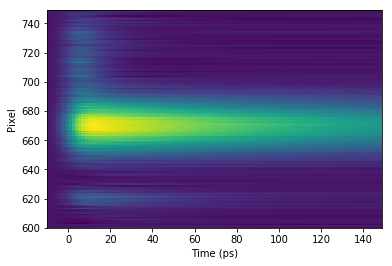

In [7]:
# Plot the fitted data

data = result.eval('dataset1')

fig = plt.figure()
plt.xlabel('Time (ps)')
plt.ylabel('Pixel')
plt.pcolormesh(time_axis, spectral_axis, data)
plt.show()